# Melanoma Cancer Classification (Benign - Malignant)
## Source: Kaggle
## <a href="https://www.kaggle.com/datasets/bhaveshmittal/melanoma-cancer-dataset" target="_blank">Click here to open data</a>
__________________________________________________________________________________________________________________________________________________________________________________
## Dataset Overview

-    **Size**: 13,900 images (224x224 pixels):
        - 6289 Malignant images
        - 5590 Benign images
-    **Purpose**: Supporting melanoma diagnosis through machine learning.

## Problem

-    Melanoma is a dangerous and aggressive form of skin cancer.
-    Accurate and timely diagnosis remains challenging with traditional methods.
-    Misdiagnosis leads to delayed treatment and poor outcomes.

## Solution


-    Enhance early detection and diagnostic accuracy.
-    Revolutionize dermatology and improve patient outcomes through AI-driven tools.


__________________________________________________________________________________________________________________________________________________________________________________



# important library

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil

## Data splitting
- **This cell is intended for single-use execution only**

In [4]:
"""
source_path = r"C:\Users\D E L L\Desktop\Deep Learning Project\test"
output_path = r"C:\Users\D E L L\Desktop\Deep Learning Project\cancer_data_split"

for split in ['val', 'test']:
    split_path = os.path.join(output_path, split)
    os.makedirs(split_path, exist_ok=True)

for disease_folder in os.listdir(source_path):
    disease_path = os.path.join(source_path, disease_folder)
    if not os.path.isdir(disease_path):
        continue
    
    images = [img for img in os.listdir(disease_path) if img.endswith(('png', 'jpg', 'jpeg'))]
    val_imgs, test_imgs = train_test_split(images, test_size=0.5, random_state=42)
    
    for split, split_imgs in zip(['val', 'test'], [val_imgs, test_imgs]):
        split_dir = os.path.join(output_path, split, disease_folder)
        os.makedirs(split_dir, exist_ok=True)
        for img in split_imgs:
            shutil.copy(os.path.join(disease_path, img), os.path.join(split_dir, img))

print("Data splitting completed.")
"""

Data splitting completed.


# Creating the Utility class
## Purpose of the Class:

-    Utility class is designed to handle image data preprocessing and augmentation for training, validation, and testing datasets.

## Key Features:

-    **Parameters**: Includes flexibility to customize image dimensions, batch size, and augmentation options (rotation, shifting, shearing, zooming, flipping).
-    **ImageDataGenerator**: Prepares augmented datasets for training

## Attributes:

-    **Directories**: Paths for training, validation, and testing datasets.
-    **Data Augmentation**: Automatically applies transformations like rotation, zoom, and flipping to enhance training data.

## Use Case:

-    Simplifies and standardizes preprocessing for deep learning models, making it modular and reusable.

In [2]:
class Utility:
    def __init__(self, train_dir, val_dir, test_dir, img_height=32, img_width=32, batch_size=32, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True):
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir
        self.img_height = img_height
        self.img_width = img_width
        self.batch_size = batch_size
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.shear_range = shear_range
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip

        self.train_datagen = ImageDataGenerator(
            rescale=1./255,
            rotation_range=self.rotation_range,
            width_shift_range=self.width_shift_range,
            height_shift_range=self.height_shift_range,
            shear_range=self.shear_range,
            zoom_range=self.zoom_range,
            horizontal_flip=self.horizontal_flip,
            fill_mode='nearest'
        )

        self.val_datagen = ImageDataGenerator(rescale=1./255)
        self.test_datagen = ImageDataGenerator(rescale=1./255)

In [3]:
utility = Utility(
    train_dir=r"C:\Users\D E L L\Desktop\Deep Learning Project\cancer_data_split\train",
    val_dir=r"C:\Users\D E L L\Desktop\Deep Learning Project\cancer_data_split\val",
    test_dir=r"C:\Users\D E L L\Desktop\Deep Learning Project\cancer_data_split\test"
)

# analyze directories
- **PurpTraining Dataose**: Counts images in each class within a directory.  
    - Training Data
    - Validation Data
    - Test Data
- **Usage**: Applied to training, validation, and test datasets.  
- **Output**: Prints class names and image counts.

In [4]:
def analyze_directories(directory):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            print(f"Class '{class_name}': {len(os.listdir(class_path))} images")
            
print("Training Data:")
analyze_directories(utility.train_dir)

print("\nValidation Data:")
analyze_directories(utility.val_dir)

print("\nTest Data:")
analyze_directories(utility.test_dir)


Training Data:
Class 'Benign': 6289 images
Class 'Malignant': 5590 images

Validation Data:
Class 'Benign': 500 images
Class 'Malignant': 500 images

Test Data:
Class 'Benign': 500 images
Class 'Malignant': 500 images


# Class Distribution Analysis

Training Class Distribution:
           Count
Benign      6289
Malignant   5590


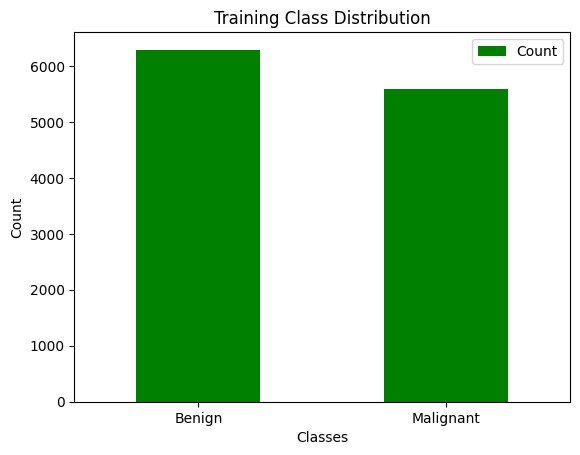

In [5]:
def class_distribution(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))
    return pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])


train_distribution = class_distribution(utility.train_dir)
val_distribution = class_distribution(utility.val_dir)
test_distribution = class_distribution(utility.test_dir)


print("Training Class Distribution:")
print(train_distribution)


train_distribution.plot(
    kind='bar',
    title="Training Class Distribution",
    color=['green' if idx == 'Benign' else 'red' for idx in train_distribution.index]
)
plt.xlabel("Classes")
plt.ylabel("Count")
plt.xticks(rotation=0)  
plt.show()


# Creating the training, validation and testing image generators
- **Purpose**: Generates data loaders for training, validation, and testing.  
- **Functionality**: Resizes, batches, and preprocesses images with `flow_from_directory`.  
- **Output**: Creates `train_generator`, `val_generator`, and `test_generator`.  
- **Prints**: Confirms creation.  

In [6]:
def create_generators(self):
    self.train_generator = self.train_datagen.flow_from_directory(
        self.train_dir,
        target_size=(self.img_height, self.img_width),
        batch_size=self.batch_size,
        color_mode='rgb',
        class_mode='categorical'
    )

    self.val_generator = self.val_datagen.flow_from_directory(
        self.val_dir,
        target_size=(self.img_height, self.img_width),
        batch_size=self.batch_size,
        color_mode='rgb',
        class_mode='categorical'
    )

    self.test_generator = self.test_datagen.flow_from_directory(
        self.test_dir,
        target_size=(self.img_height, self.img_width),
        batch_size=self.batch_size,
        color_mode='rgb',
        class_mode='categorical'
    )
    print("Generators Created")
Utility.create_generators = create_generators

# Building the model architecture
## **Key Points**

- **Purpose**: Defines a convolutional neural network (CNN) for image classification.  

- **Architecture**:
   - **Input Layer**: Accepts images with dimensions `(img_height, img_width, 3)`.
   - **Convolution Layers**: Two `Conv2D` layers with ReLU activation and batch normalization for feature extraction.
   - **Pooling**: Two `MaxPooling2D` layers for dimensionality reduction.
   - **Fully Connected Layers**: Four dense layers (64, 32, 16, 8 neurons) with ReLU activation for learning complex patterns.
   - **Dropout**: Reduces overfitting by randomly deactivating neurons.
   - **Output Layer**: A dense layer with 2 neurons and softmax activation for binary classification.

- **Output**: Returns the compiled model ready for training.  

- **Prints**: Confirms model creation (currently unreachable after `return`, can be moved).

In [7]:
def build_model(self):
    model = Sequential([
        Input(shape=(self.img_height, self.img_width, 3)),
        Conv2D(64, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Conv2D(128, (3, 3), activation='relu', padding="same"),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(16, activation='relu'),
        Dense(8, activation='relu'),

        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    return model
    print("Model built successfully")
Utility.build_model = build_model

# Compiling the model

In [8]:
def compile_model(self, model, learning_rate=0.001):
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
    print("Model Compiled successfully")
Utility.compile_model = compile_model

# Training the model

In [9]:
def train_model(self, model, epochs=20):
    history = model.fit(
        self.train_generator,
        epochs=epochs,
        validation_data=self.val_generator
    )
    return history
    print("Model trained successfully")
Utility.train_model = train_model

# Model Evaluation

In [10]:
def evaluate_model(self, model):
    test_loss, test_acc = model.evaluate(self.test_generator)

    print('Test Loss:', test_loss)
    print('Test Accuracy:', test_acc)

    return test_loss, test_acc
Utility.evaluate_model = evaluate_model

# Creating the Helper class
- **Purpose**: The Helper class manages the training workflow using the Utility class.
- Key Function (run):

    - Reinitializes the Utility object with updated parameters.
    - Creates data generators (create_generators).
    - Builds, compiles, and trains the model (build_model, compile_model, train_model).
    - Evaluates the model on the test set (evaluate_model).

- **Output**: Returns the trained model, test loss, and test accuracy.

In [11]:
class Helper:
    def __init__(self, utility):
        self.utility = utility

    def run(self, learning_rate=0.001, epochs=20, batch_size=32, img_height=32, img_width=32, rotation_range=20, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=True):
        self.utility.__init__(
            self.utility.train_dir,
            self.utility.val_dir,
            self.utility.test_dir,
            img_height=img_height,
            img_width=img_width,
            batch_size=batch_size,
            rotation_range=rotation_range,
            width_shift_range=width_shift_range,
            height_shift_range=height_shift_range,
            shear_range=shear_range,
            zoom_range=zoom_range,
            horizontal_flip=horizontal_flip
        )

        self.utility.create_generators()
        model = self.utility.build_model()
        model = self.utility.compile_model(model, learning_rate=learning_rate)
        history = self.utility.train_model(model, epochs=epochs)
        test_loss, test_acc = self.utility.evaluate_model(model)

        return model, test_loss, test_acc

# Running model 1

In [12]:
helper = Helper(utility)
scenario_1, loss_1, acc_1 = helper.run(
    learning_rate=0.0005,
    epochs=10,
    batch_size=64,
    img_height=32,
    img_width=32,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

Found 11879 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Generators Created
Epoch 1/10


D:\Downloads\anaconda\envs\Ahmed\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


186/186 ━━━━━━━━━━━━━━━━━━━━ 26s 129ms/step - accuracy: 0.7145 - loss: 0.5491 - val_accuracy: 0.7090 - val_loss: 0.5908
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.7556 - loss: 0.4534 - val_accuracy: 0.6190 - val_loss: 0.6306
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 19s 100ms/step - accuracy: 0.7754 - loss: 0.4322 - val_accuracy: 0.6560 - val_loss: 0.5392
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 18s 99ms/step - accuracy: 0.7912 - loss: 0.4133 - val_accuracy: 0.8660 - val_loss: 0.3574
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.7852 - loss: 0.4352 - val_accuracy: 0.8140 - val_loss: 0.3885
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.7984 - loss: 0.4172 - val_accuracy: 0.8190 - val_loss: 0.3825
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 110ms/step - accuracy: 0.8034 - loss: 0.4040 - val_accuracy: 0.6830 - val_loss: 0.6079
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.8057 - loss: 0.3929 - val_a

# save model 1

In [14]:
#scenario_1.save("model.h5")

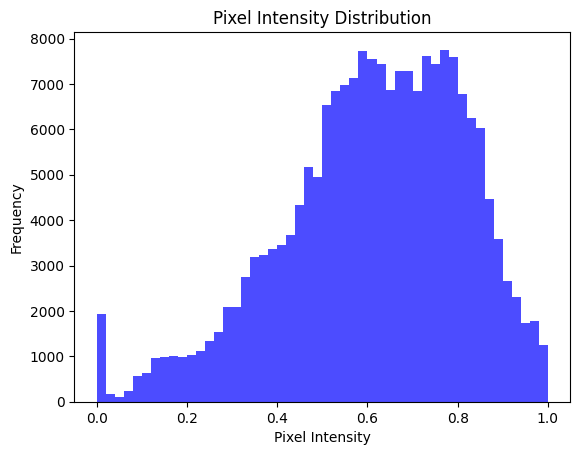

In [42]:
def plot_pixel_histogram(generator):
    x_batch, y_batch = next(generator)
    plt.hist(x_batch.flatten(), bins=50, color='blue', alpha=0.7)
    plt.title("Pixel Intensity Distribution")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

plot_pixel_histogram(utility.train_generator)

__________________________________________________________________________________________________________________________________________________________________________________

# Running model 2

In [15]:
helper = Helper(utility)
scenario_2, loss_2, acc_2 = helper.run(
    learning_rate=0.0005,
    epochs=10,
    batch_size=32,
    img_height=8,
    img_width=8,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True
)

Found 11879 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Generators Created
Epoch 1/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.7228 - loss: 0.5363 - val_accuracy: 0.7930 - val_loss: 0.5239
Epoch 2/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.7822 - loss: 0.4685 - val_accuracy: 0.8360 - val_loss: 0.4115
Epoch 3/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.7825 - loss: 0.4640 - val_accuracy: 0.8190 - val_loss: 0.3911
Epoch 4/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - accuracy: 0.7944 - loss: 0.4448 - val_accuracy: 0.7910 - val_loss: 0.4590
Epoch 5/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 24ms/step - accuracy: 0.8027 - loss: 0.4309 - val_accuracy: 0.8870 - val_loss: 0.3530
Epoch 6/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8069 - loss: 0.4261 - val_accuracy: 0.8520 - val_loss: 0.3791
Epoch 7/10
372/372 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - accuracy: 0.8106 - loss:

# save model 2

In [17]:
scenario_2.save("Model_2.h5")

__________________________________________________________________________________________________________________________________________________________________________________

# Comparing Accuracies among Models

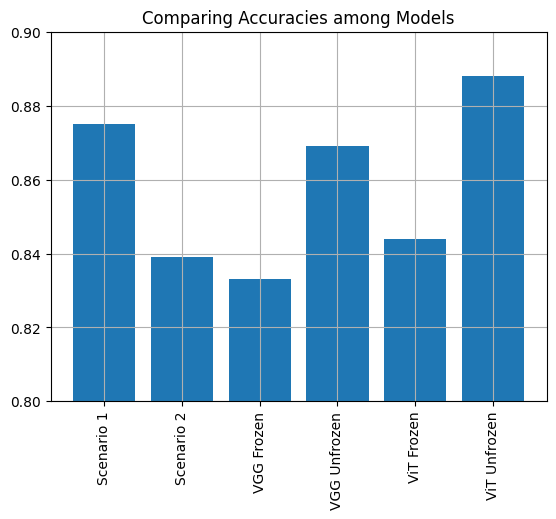

In [51]:
models = ['Scenario 1', 'Scenario 2']
accuracies = [acc_1, acc_2]
losses = [loss_1, loss_2]

colors = ['skyblue', 'salmon']

plt.bar(models, accuracies, color=colors)
plt.grid(axis='y')
plt.title("Comparing Accuracies among Models")
plt.ylim(0.8, 0.9)
plt.xticks(rotation=0)
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.show()


__________________________________________________________________________________________________________________________________________________________________________________

# **Model Performance Summary**

- **Model 1** achieved a **test accuracy of 86.5%**, demonstrating strong performance.  
- **Model 2** reached a **test accuracy of 80.4%**, performing slightly lower than Model 1.  

**Conclusion**: Model 1 outperforms Model 2, making it the better choice for this task based on accuracy.